## 1. Import Libraries

In [14]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries
from darts.models import RandomForest
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, rmse, mae, r2_score
import shap
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')


COLORS = {
    'IHSG': '#2E7D32',
    'IHSG_light': '#4CAF50',
    'IHSG_dark': '#1B5E20',    
    'Inflation': '#D32F2F',
    'BI_Rate': '#F57C00',        
    'M2_YoY': '#1976D2',         
    'USDIDR': '#7B1FA2',         
    'NPL_Ratio': '#C2185B',      
    'train': '#2E7D32',
    'actual': '#1976D2',
    'predicted': '#D32F2F',
    'error': '#9E9E9E',
    'split_line': '#616161',
}

COLOR_PALETTE = ['#2E7D32', '#D32F2F', '#F57C00', '#1976D2', '#7B1FA2', '#C2185B']

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100          # Display DPI
plt.rcParams['savefig.dpi'] = 300         # Export DPI (publication quality)
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1

# font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'Georgia']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# line 
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 0.8

# grid
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linewidth'] = 0.5

# legend
plt.rcParams['legend.framealpha'] = 0.9
plt.rcParams['legend.edgecolor'] = '0.8'

## Data Gathering and preprocessing

In [15]:
# data from bloomberg terminal
df = pd.read_csv('model1.csv')

# display basic info
print("="*60)
print("DATA OVERVIEW")
print("="*60)
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumns: {df.columns.tolist()}")
print("\n" + "="*60)
print("FIRST 10 ROWS")
print("="*60)
df.head(10)

DATA OVERVIEW
Shape: 121 rows × 7 columns

Columns: ['Date', 'IHSG', 'Inflation Rate YoY', 'Money Supply M2 YoY', 'USDIDR', 'BI Interest Rate', 'npl_ratio']

FIRST 10 ROWS


,Date,IHSG,Inflation Rate YoY,Money Supply M2 YoY,USDIDR,BI Interest Rate,npl_ratio
0,31/01/2025,7109.196,0.76,5.46,16300,5.75%,2.18%
1,31/12/2024,7079.905,1.57,4.76,16102,6.00%,2.08%
2,30/11/2024,7114.266,1.55,6.53,15845,6.00%,2.19%
3,31/10/2024,7574.019,1.71,6.77,15697,6.00%,2.20%
4,30/09/2024,7527.929,1.84,7.19,15140,6.00%,2.21%
5,31/08/2024,7670.733,2.12,7.30,15455,6.25%,2.26%
6,31/07/2024,7255.762,2.13,7.59,16260,6.25%,2.27%
7,30/06/2024,7063.577,2.51,7.67,16375,6.25%,2.26%
8,31/05/2024,6970.736,2.84,7.59,16250,6.25%,2.34%
9,30/04/2024,7234.197,3.00,6.87,16260,6.25%,2.33%


### Data Preprocessing

In [16]:
# Check data types and missing values
print("="*60)
print("DATA TYPES & MISSING VALUES")
print("="*60)
df.info()
print("\n" + "="*60)
print("MISSING VALUES PER COLUMN")
print("="*60)
print(df.isnull().sum())

DATA TYPES & MISSING VALUES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 121 non-null    object 
 1   IHSG                 121 non-null    float64
 2   Inflation Rate YoY   121 non-null    float64
 3   Money Supply M2 YoY  121 non-null    float64
 4   USDIDR               121 non-null    int64  
 5   BI Interest Rate     121 non-null    object 
 6   npl_ratio            121 non-null    object 
dtypes: float64(3), int64(1), object(3)
memory usage: 6.7+ KB

MISSING VALUES PER COLUMN
Date                   0
IHSG                   0
Inflation Rate YoY     0
Money Supply M2 YoY    0
USDIDR                 0
BI Interest Rate       0
npl_ratio              0
dtype: int64


In [17]:
df_clean = df.copy()

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%d/%m/%Y')

pct_columns = ['BI Interest Rate', 'npl_ratio']
for col in pct_columns:
    if df_clean[col].dtype == 'object':
        df_clean[col] = df_clean[col].str.replace('%', '').astype(float)

df_clean = df_clean.sort_values('Date').reset_index(drop=True)

df_clean.columns = ['Date', 'IHSG', 'Inflation_YoY', 'M2_YoY', 'USDIDR', 'BI_Rate', 'NPL_Ratio']

print("="*60)
print("CLEANED DATA")
print("="*60)
print(f"Date Range: {df_clean['Date'].min()} to {df_clean['Date'].max()}")
print(f"Total Months: {len(df_clean)}")
print("\nData Types after cleaning:")
print(df_clean.dtypes)
print("\n")
df_clean.head(10)

CLEANED DATA
Date Range: 2015-01-31 00:00:00 to 2025-01-31 00:00:00
Total Months: 121

Data Types after cleaning:
Date             datetime64[ns]
IHSG                    float64
Inflation_YoY           float64
M2_YoY                  float64
USDIDR                    int64
BI_Rate                 float64
NPL_Ratio               float64
dtype: object




,Date,IHSG,Inflation_YoY,M2_YoY,USDIDR,BI_Rate,NPL_Ratio
0,2015-01-31,5289.404,6.96,14.31,12755,7.75,2.37
1,2015-02-28,5450.294,6.29,16.04,12928,7.50,2.43
2,2015-03-31,5518.675,6.38,16.26,13075,7.50,2.40
3,2015-04-30,5086.425,6.79,14.88,12964,7.50,2.48
4,2015-05-31,5216.379,7.15,13.42,13225,7.50,2.58
5,2015-06-30,4910.658,7.26,12.98,13333,7.50,2.56
6,2015-07-31,4802.529,7.26,12.50,13531,7.50,2.70
7,2015-08-31,4509.607,7.18,13.32,14053,7.50,2.76
8,2015-09-30,4223.908,6.83,12.43,14651,7.50,2.71
9,2015-10-31,4455.180,6.25,10.40,13695,7.50,2.68


In [18]:
# Descriptive statistics
print("="*60)
print("DESCRIPTIVE STATISTICS")
print("="*60)
df_clean.describe().round(2)

DESCRIPTIVE STATISTICS


,Date,IHSG,Inflation_YoY,M2_YoY,USDIDR,BI_Rate,NPL_Ratio
count,121,121.00,121.00,121.00,121.00,121.00,121.00
mean,2020-01-30 02:58:30.743801600,6077.38,3.36,8.81,14363.80,5.25,2.77
min,2015-01-31 00:00:00,4223.91,0.76,3.35,12755.00,3.50,2.08
25%,2017-07-31 00:00:00,5386.69,2.48,6.77,13655.00,4.25,2.52
50%,2020-01-31 00:00:00,6056.12,3.18,8.18,14273.00,5.25,2.76
75%,2022-07-31 00:00:00,6843.24,3.83,10.53,14903.00,6.00,3.05
max,2025-01-31 00:00:00,7670.73,7.26,16.26,16375.00,7.75,3.35
std,NaN,850.61,1.49,2.74,895.79,1.24,0.32


## 4. Exploratory Data Analysis (EDA)

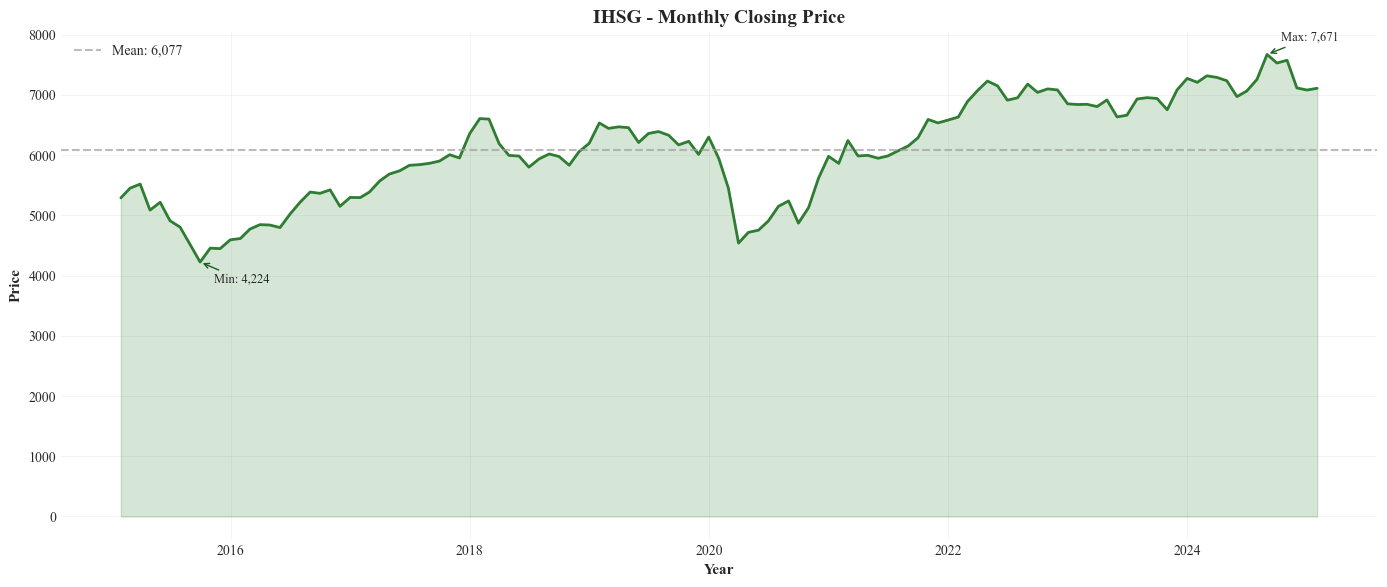

✅ Figure saved: eda_ihsg.png (300 DPI)


In [21]:
# =============================================================================
# PLOT 1: IHSG Time Series (Target Variable)
# =============================================================================
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df_clean['Date'], df_clean['IHSG'], color=COLORS['IHSG'], linewidth=2)
ax.fill_between(df_clean['Date'], df_clean['IHSG'], alpha=0.2, color=COLORS['IHSG'])

# Add mean line
ihsg_mean = df_clean['IHSG'].mean()
ax.axhline(y=ihsg_mean, color=COLORS['error'], linestyle='--', alpha=0.7, 
           label=f'Mean: {ihsg_mean:,.0f}')

ax.set_title('IHSG - Monthly Closing Price', fontsize=14, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Price')
ax.legend(loc='upper left', framealpha=0.9)
ax.grid(True, alpha=0.3)

# Add annotations for min/max
ihsg_max_idx = df_clean['IHSG'].idxmax()
ihsg_min_idx = df_clean['IHSG'].idxmin()
ax.annotate(f"Max: {df_clean.loc[ihsg_max_idx, 'IHSG']:,.0f}", 
            xy=(df_clean.loc[ihsg_max_idx, 'Date'], df_clean.loc[ihsg_max_idx, 'IHSG']),
            xytext=(10, 10), textcoords='offset points', fontsize=9,
            arrowprops=dict(arrowstyle='->', color=COLORS['IHSG_dark']))
ax.annotate(f"Min: {df_clean.loc[ihsg_min_idx, 'IHSG']:,.0f}", 
            xy=(df_clean.loc[ihsg_min_idx, 'Date'], df_clean.loc[ihsg_min_idx, 'IHSG']),
            xytext=(10, -15), textcoords='offset points', fontsize=9,
            arrowprops=dict(arrowstyle='->', color=COLORS['IHSG_dark']))

plt.tight_layout()
plt.savefig('eda_ihsg.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: eda_ihsg.png (300 DPI)")

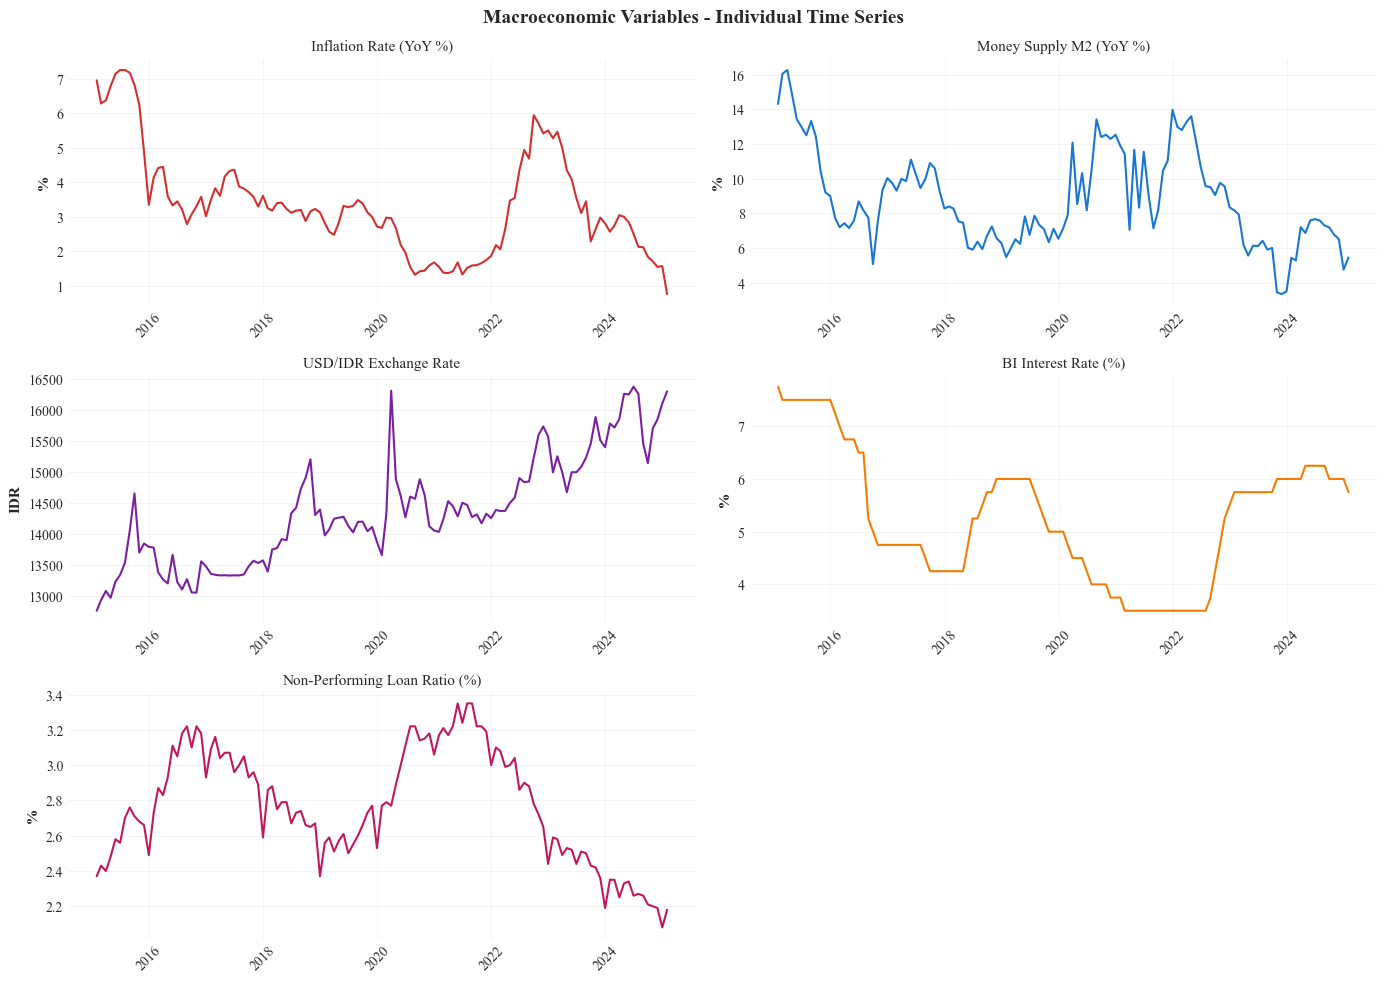

✅ Figure saved: eda_covariates_individual.png (300 DPI)


In [24]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Macroeconomic Variables - Individual Time Series', fontsize=14, fontweight='bold')

plot_config = [
    ('Inflation_YoY', COLORS['Inflation'], 'Inflation Rate (YoY %)', '%'),
    ('M2_YoY', COLORS['M2_YoY'], 'Money Supply M2 (YoY %)', '%'),
    ('USDIDR', COLORS['USDIDR'], 'USD/IDR Exchange Rate', 'IDR'),
    ('BI_Rate', COLORS['BI_Rate'], 'BI Interest Rate (%)', '%'),
    ('NPL_Ratio', COLORS['NPL_Ratio'], 'Non-Performing Loan Ratio (%)', '%'),
]

for idx, (col, color, title, ylabel) in enumerate(plot_config):
    ax = axes[idx // 2, idx % 2]
    ax.plot(df_clean['Date'], df_clean[col], color=color, linewidth=1.5)
    ax.set_title(title, fontsize=11)
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

# Hide the last empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.savefig('eda_covariates_individual.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: eda_covariates_individual.png (300 DPI)")

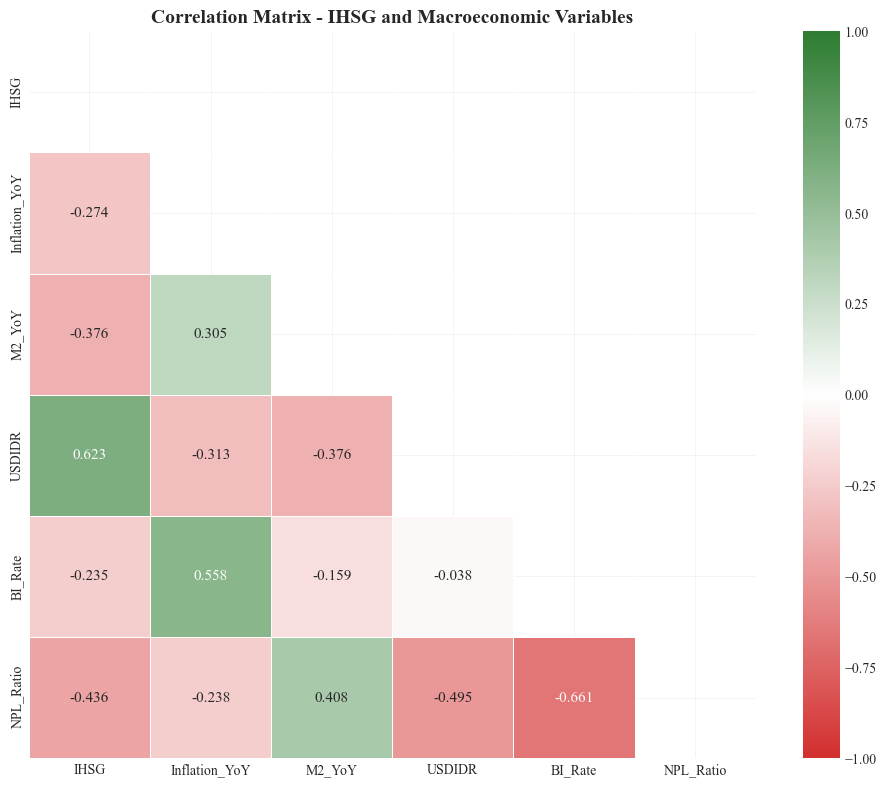

✅ Figure saved: correlation_matrix.png (300 DPI)

CORRELATION WITH IHSG
USDIDR          : +0.6227 (Moderate ↑ Positive)
BI_Rate         : -0.2353 (Weak ↓ Negative)
Inflation_YoY   : -0.2740 (Weak ↓ Negative)
M2_YoY          : -0.3763 (Weak ↓ Negative)
NPL_Ratio       : -0.4360 (Moderate ↓ Negative)


In [25]:
# Correlation Analysis with custom colormap (Green-White-Red)
fig, ax = plt.subplots(figsize=(10, 8))

corr_matrix = df_clean.drop('Date', axis=1).corr()

# Custom colormap: Green (positive with IHSG) to Red (negative)
from matplotlib.colors import LinearSegmentedColormap
colors_cmap = ['#D32F2F', '#FFFFFF', '#2E7D32']  # Red - White - Green
custom_cmap = LinearSegmentedColormap.from_list('thesis_cmap', colors_cmap, N=256)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap=custom_cmap, 
            center=0, square=True, linewidths=0.5, ax=ax,
            annot_kws={'size': 11}, vmin=-1, vmax=1)

ax.set_title('Correlation Matrix - IHSG and Macroeconomic Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: correlation_matrix.png (300 DPI)")
print("\n" + "="*60)
print("CORRELATION WITH IHSG")
print("="*60)
ihsg_corr = corr_matrix['IHSG'].drop('IHSG').sort_values(ascending=False)
for var, corr in ihsg_corr.items():
    direction = "↑ Positive" if corr > 0 else "↓ Negative"
    strength = "Strong" if abs(corr) > 0.7 else "Moderate" if abs(corr) > 0.4 else "Weak"
    print(f"{var:15} : {corr:+.4f} ({strength} {direction})")

## 5. Create Darts TimeSeries Objects

In [9]:
# Define target and covariate columns
TARGET_COL = 'IHSG'
COVARIATE_COLS = ['Inflation_YoY', 'M2_YoY', 'USDIDR', 'BI_Rate', 'NPL_Ratio']

# Set Date as index with monthly frequency
df_ts = df_clean.set_index('Date')
df_ts = df_ts.asfreq('ME')  # Month End frequency

# Create target TimeSeries
target_series = TimeSeries.from_dataframe(
    df_ts, 
    value_cols=TARGET_COL,
    fill_missing_dates=True
)

# Create covariates TimeSeries
covariates = TimeSeries.from_dataframe(
    df_ts,
    value_cols=COVARIATE_COLS,
    fill_missing_dates=True
)

print("="*60)
print("DARTS TIMESERIES CREATED")
print("="*60)
print(f"Target Series (IHSG):")
print(f"  - Start: {target_series.start_time()}")
print(f"  - End: {target_series.end_time()}")
print(f"  - Length: {len(target_series)} time steps")
print(f"  - Frequency: {target_series.freq}")
print(f"\nCovariates:")
print(f"  - Components: {covariates.components.tolist()}")
print(f"  - Length: {len(covariates)} time steps")

DARTS TIMESERIES CREATED
Target Series (IHSG):
  - Start: 2015-01-31 00:00:00
  - End: 2025-01-31 00:00:00
  - Length: 121 time steps
  - Frequency: <MonthEnd>

Covariates:
  - Components: ['Inflation_YoY', 'M2_YoY', 'USDIDR', 'BI_Rate', 'NPL_Ratio']
  - Length: 121 time steps


## 6. Train/Test Split and Scaling

In [10]:
# Train/Test Split (80/20)
TRAIN_RATIO = 0.8
split_point = int(len(target_series) * TRAIN_RATIO)

train_target = target_series[:split_point]
test_target = target_series[split_point:]

train_cov = covariates[:split_point]
test_cov = covariates[split_point:]

# Scale the data using Darts Scaler
scaler_target = Scaler()
scaler_cov = Scaler()

# Fit on training data only to avoid data leakage
train_target_scaled = scaler_target.fit_transform(train_target)
test_target_scaled = scaler_target.transform(test_target)

train_cov_scaled = scaler_cov.fit_transform(train_cov)
test_cov_scaled = scaler_cov.transform(test_cov)

# Full scaled series for backtesting
target_scaled = scaler_target.transform(target_series)
cov_scaled = scaler_cov.transform(covariates)

print("="*60)
print("TRAIN/TEST SPLIT")
print("="*60)
print(f"Train Period: {train_target.start_time()} to {train_target.end_time()} ({len(train_target)} months)")
print(f"Test Period:  {test_target.start_time()} to {test_target.end_time()} ({len(test_target)} months)")
print(f"\nTrain/Test Ratio: {TRAIN_RATIO*100:.0f}% / {(1-TRAIN_RATIO)*100:.0f}%")

TRAIN/TEST SPLIT
Train Period: 2015-01-31 00:00:00 to 2022-12-31 00:00:00 (96 months)
Test Period:  2023-01-31 00:00:00 to 2025-01-31 00:00:00 (25 months)

Train/Test Ratio: 80% / 20%


## 7. Hyperparameter Tuning with GridSearch

In [11]:
# Define hyperparameter grid for RandomForestModel
param_grid = {
    'lags': [3, 6, 12],                        # Target lags (months)
    'lags_past_covariates': [3, 6, 12],        # Covariate lags
    'n_estimators': [100, 200, 300],           # Number of trees
    'max_depth': [5, 10, None],                # Maximum tree depth
}

print("="*60)
print("HYPERPARAMETER GRID")
print("="*60)
for param, values in param_grid.items():
    print(f"{param}: {values}")

total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)
print(f"\nTotal combinations to evaluate: {total_combinations}")

HYPERPARAMETER GRID
lags: [3, 6, 12]
lags_past_covariates: [3, 6, 12]
n_estimators: [100, 200, 300]
max_depth: [5, 10, None]

Total combinations to evaluate: 81


In [15]:
# Perform GridSearch
print("="*60)
print("RUNNING GRIDSEARCH (this may take a few minutes...)")
print("="*60)

# Note: past_covariates must cover both training AND validation period
# So we use cov_scaled (full covariates) instead of train_cov_scaled
best_model, best_params, best_score = RandomForest.gridsearch(
    parameters=param_grid,
    series=train_target_scaled,
    past_covariates=cov_scaled,  # Full covariates to cover validation period
    val_series=test_target_scaled,
    metric=mape,
    verbose=True,
    n_jobs=-1,  # Use all CPU cores
)

print("\n" + "="*60)
print("GRIDSEARCH RESULTS")
print("="*60)
print(f"Best MAPE Score: {best_score:.4f}%")
print(f"\nBest Hyperparameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

RUNNING GRIDSEARCH (this may take a few minutes...)


gridsearch:   0%|          | 0/81 [00:00<?, ?it/s]


GRIDSEARCH RESULTS
Best MAPE Score: 7.6039%

Best Hyperparameters:
  lags: 12
  lags_past_covariates: 3
  n_estimators: 100
  max_depth: 5


## 8. Train Best Model and Generate Predictions

In [16]:
# Create and train the best model with optimal hyperparameters
final_model = RandomForest(
    lags=best_params['lags'],
    lags_past_covariates=best_params['lags_past_covariates'],
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    output_chunk_length=1,
    random_state=42
)

# Fit on full training data
final_model.fit(train_target_scaled, past_covariates=train_cov_scaled)

# Generate predictions on test set
n_test = len(test_target_scaled)
predictions_scaled = final_model.predict(n=n_test, past_covariates=cov_scaled)

# Inverse transform to original scale
predictions = scaler_target.inverse_transform(predictions_scaled)
test_actual = scaler_target.inverse_transform(test_target_scaled)

print("="*60)
print("MODEL TRAINED AND PREDICTIONS GENERATED")
print("="*60)
print(f"Prediction Period: {predictions.start_time()} to {predictions.end_time()}")
print(f"Number of predictions: {len(predictions)}")

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


MODEL TRAINED AND PREDICTIONS GENERATED
Prediction Period: 2023-01-31 00:00:00 to 2025-01-31 00:00:00
Number of predictions: 25


## 9. Model Evaluation

In [17]:
# Calculate evaluation metrics
mape_score = mape(test_actual, predictions)
rmse_score = rmse(test_actual, predictions)
mae_score = mae(test_actual, predictions)
r2 = r2_score(test_actual, predictions)

print("="*60)
print("MODEL EVALUATION METRICS")
print("="*60)
print(f"MAPE (Mean Absolute Percentage Error): {mape_score:.4f}%")
print(f"RMSE (Root Mean Square Error):         {rmse_score:.4f}")
print(f"MAE (Mean Absolute Error):             {mae_score:.4f}")
print(f"R² Score:                              {r2:.4f}")
print("="*60)

# Interpretation
print("\n📊 INTERPRETATION:")
if mape_score < 5:
    print(f"  ✅ MAPE < 5%: Excellent forecasting accuracy")
elif mape_score < 10:
    print(f"  ✅ MAPE < 10%: Good forecasting accuracy")
elif mape_score < 20:
    print(f"  ⚠️ MAPE < 20%: Reasonable forecasting accuracy")
else:
    print(f"  ❌ MAPE > 20%: Poor forecasting accuracy")

MODEL EVALUATION METRICS
MAPE (Mean Absolute Percentage Error): 3.1449%
RMSE (Root Mean Square Error):         285.6206
MAE (Mean Absolute Error):             226.3308
R² Score:                              -0.1513

📊 INTERPRETATION:
  ✅ MAPE < 5%: Excellent forecasting accuracy


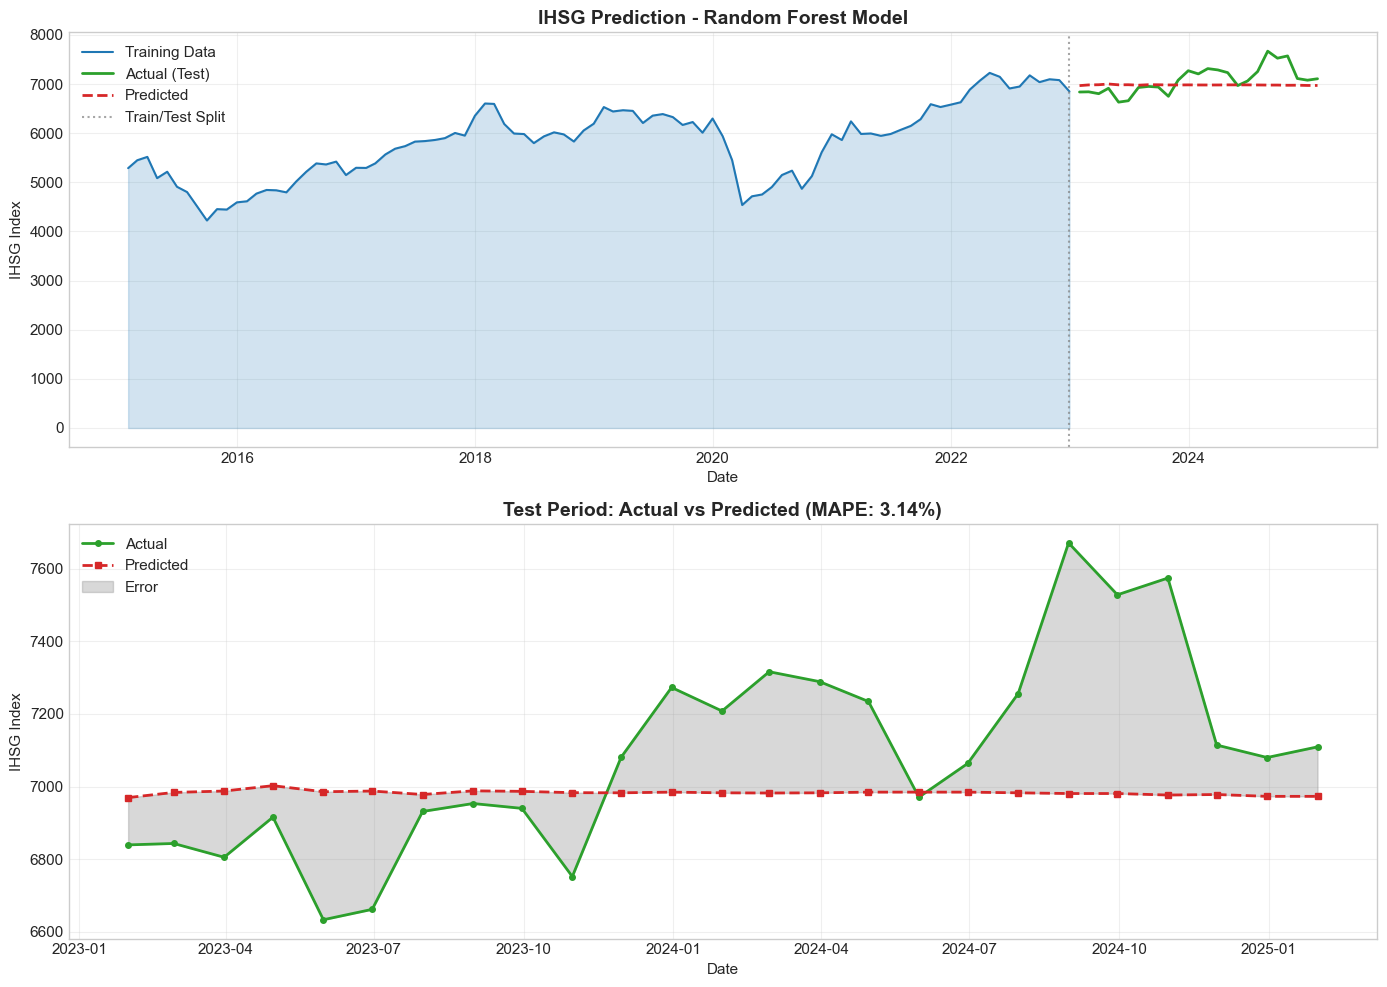

In [ ]:
# Visualization: Actual vs Predicted with thesis color palette
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Full time series with predictions
ax1 = axes[0]
ax1.plot(train_target.time_index, train_target.values(), 
         label='Training Data', color=COLORS['train'], linewidth=1.5, alpha=0.7)
ax1.plot(test_actual.time_index, test_actual.values(), 
         label='Actual (Test)', color=COLORS['actual'], linewidth=2)
ax1.plot(predictions.time_index, predictions.values(), 
         label='Predicted', color=COLORS['predicted'], linewidth=2, linestyle='--')
ax1.axvline(x=train_target.end_time(), color=COLORS['split_line'], linestyle=':', linewidth=1.5, label='Train/Test Split')
ax1.fill_between(train_target.time_index, train_target.values().flatten(), alpha=0.15, color=COLORS['train'])
ax1.set_title('IHSG Prediction - Random Forest Model', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('IHSG Index')
ax1.legend(loc='upper left', framealpha=0.9)
ax1.grid(True, alpha=0.3)

# Plot 2: Test period close-up
ax2 = axes[1]
ax2.plot(test_actual.time_index, test_actual.values(), 
         label='Actual', color=COLORS['actual'], linewidth=2, marker='o', markersize=5)
ax2.plot(predictions.time_index, predictions.values(), 
         label='Predicted', color=COLORS['predicted'], linewidth=2, linestyle='--', marker='s', markersize=5)
ax2.fill_between(test_actual.time_index, 
                  test_actual.values().flatten(), 
                  predictions.values().flatten(), 
                  alpha=0.25, color=COLORS['error'], label='Prediction Error')
ax2.set_title(f'Test Period: Actual vs Predicted (MAPE: {mape_score:.2f}%)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('IHSG Index')
ax2.legend(loc='upper left', framealpha=0.9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: prediction_results.png (300 DPI)")

## 10. Feature Importance with SHAP

In [19]:
# Extract the underlying sklearn RandomForest estimator from darts model
# The darts model wraps sklearn's RandomForestRegressor
rf_estimator = final_model.model.estimators_[0]

# Prepare feature matrix for SHAP
# We need to reconstruct the lagged features that the model uses
lags = best_params['lags']
lags_cov = best_params['lags_past_covariates']

# Create lagged feature dataframe
def create_lagged_features(target_df, cov_df, target_lags, cov_lags):
    """Create lagged features for SHAP analysis"""
    features = pd.DataFrame(index=target_df.index[max(target_lags, cov_lags):])
    
    # Target lags
    for lag in range(1, target_lags + 1):
        features[f'IHSG_lag{lag}'] = target_df['IHSG'].shift(lag).values[max(target_lags, cov_lags):]
    
    # Covariate lags
    for col in cov_df.columns:
        for lag in range(1, cov_lags + 1):
            features[f'{col}_lag{lag}'] = cov_df[col].shift(lag).values[max(target_lags, cov_lags):]
    
    return features.dropna()

# Prepare data
target_df = df_clean.set_index('Date')[['IHSG']]
cov_df = df_clean.set_index('Date')[COVARIATE_COLS]

X_features = create_lagged_features(target_df, cov_df, lags, lags_cov)

print("="*60)
print("FEATURE MATRIX FOR SHAP")
print("="*60)
print(f"Feature matrix shape: {X_features.shape}")
print(f"\nFeatures ({len(X_features.columns)}):")
for i, col in enumerate(X_features.columns, 1):
    print(f"  {i}. {col}")

FEATURE MATRIX FOR SHAP
Feature matrix shape: (109, 27)

Features (27):
  1. IHSG_lag1
  2. IHSG_lag2
  3. IHSG_lag3
  4. IHSG_lag4
  5. IHSG_lag5
  6. IHSG_lag6
  7. IHSG_lag7
  8. IHSG_lag8
  9. IHSG_lag9
  10. IHSG_lag10
  11. IHSG_lag11
  12. IHSG_lag12
  13. Inflation_YoY_lag1
  14. Inflation_YoY_lag2
  15. Inflation_YoY_lag3
  16. M2_YoY_lag1
  17. M2_YoY_lag2
  18. M2_YoY_lag3
  19. USDIDR_lag1
  20. USDIDR_lag2
  21. USDIDR_lag3
  22. BI_Rate_lag1
  23. BI_Rate_lag2
  24. BI_Rate_lag3
  25. NPL_Ratio_lag1
  26. NPL_Ratio_lag2
  27. NPL_Ratio_lag3


In [20]:
# Train a standalone RandomForest model for SHAP analysis
from sklearn.ensemble import RandomForestRegressor

# Prepare target (shifted to align with features)
y_target = target_df['IHSG'].values[max(lags, lags_cov) + 1:]  # +1 for next month prediction
X_train = X_features.iloc[:-1].values  # Remove last row to match y_target length

# Ensure alignment
min_len = min(len(X_train), len(y_target))
X_train = X_train[:min_len]
y_target = y_target[:min_len]

# Train RF model for SHAP
rf_shap = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    random_state=42,
    n_jobs=-1
)
rf_shap.fit(X_train, y_target)

print("="*60)
print("RANDOM FOREST FOR SHAP ANALYSIS")
print("="*60)
print(f"Model fitted on {X_train.shape[0]} samples with {X_train.shape[1]} features")
print(f"R² Score: {rf_shap.score(X_train, y_target):.4f}")

RANDOM FOREST FOR SHAP ANALYSIS
Model fitted on 108 samples with 27 features
R² Score: 0.9759


In [21]:
# SHAP Analysis
print("="*60)
print("COMPUTING SHAP VALUES (this may take a moment...)")
print("="*60)

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_shap)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# Create DataFrame with feature names
X_train_df = pd.DataFrame(X_train, columns=X_features.columns[:-1] if len(X_features.columns) > X_train.shape[1] else X_features.columns[:X_train.shape[1]])

print("✅ SHAP values computed successfully!")

COMPUTING SHAP VALUES (this may take a moment...)
✅ SHAP values computed successfully!


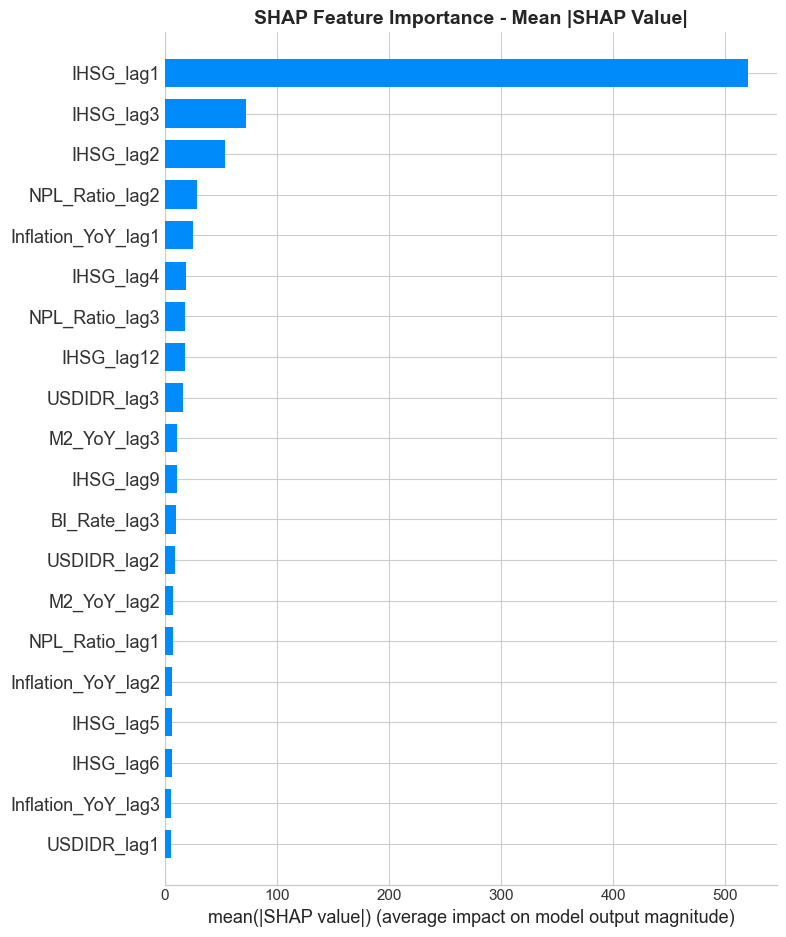

In [ ]:
# SHAP Summary Plot (Bar)
fig, ax = plt.subplots(figsize=(12, 8))
shap.summary_plot(shap_values, X_train_df, plot_type="bar", show=False, color=COLORS['IHSG'])
plt.title('SHAP Feature Importance - Mean |SHAP Value|', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('shap_importance_bar.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: shap_importance_bar.png (300 DPI)")

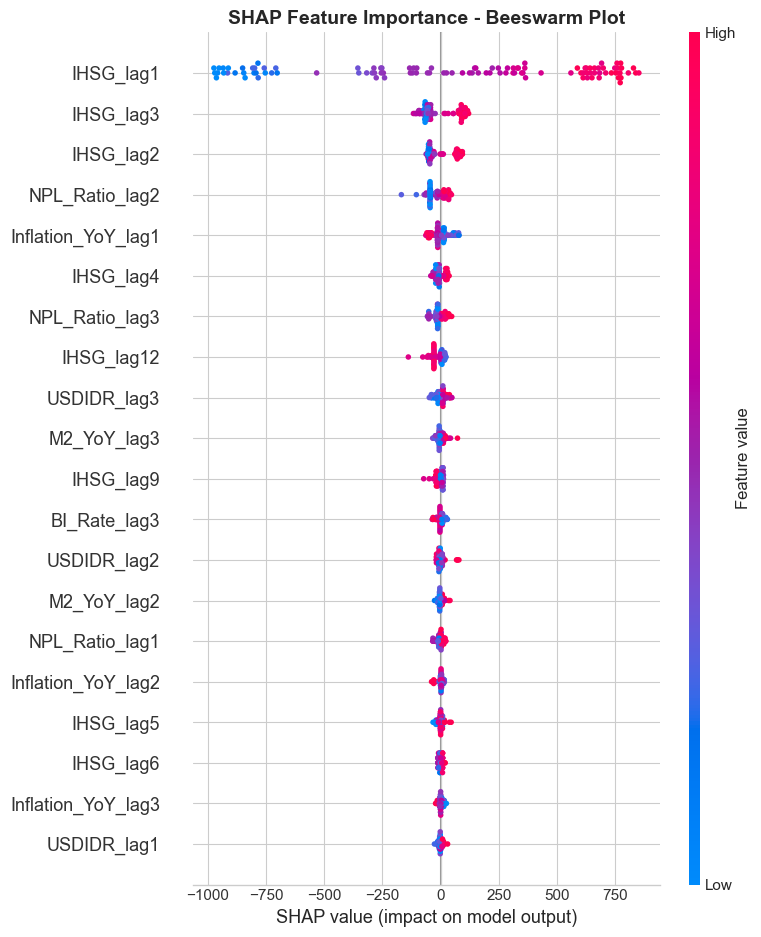

In [ ]:
# SHAP Summary Plot (Beeswarm) with custom colormap
fig, ax = plt.subplots(figsize=(12, 10))

# Custom colormap for SHAP beeswarm (Green gradient)
from matplotlib.colors import LinearSegmentedColormap
shap_cmap = LinearSegmentedColormap.from_list('shap_green', ['#C8E6C9', '#2E7D32'], N=256)

shap.summary_plot(shap_values, X_train_df, show=False, cmap=shap_cmap)
plt.title('SHAP Feature Importance - Beeswarm Plot', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('shap_importance_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: shap_importance_beeswarm.png (300 DPI)")

In [24]:
# Calculate aggregated feature importance by variable (not by lag)
feature_importance_by_var = {}

for col in X_train_df.columns:
    # Extract variable name (remove lag suffix)
    if '_lag' in col:
        var_name = col.rsplit('_lag', 1)[0]
    else:
        var_name = col
    
    col_idx = list(X_train_df.columns).index(col)
    importance = np.abs(shap_values[:, col_idx]).mean()
    
    if var_name not in feature_importance_by_var:
        feature_importance_by_var[var_name] = 0
    feature_importance_by_var[var_name] += importance

# Sort by importance
sorted_importance = dict(sorted(feature_importance_by_var.items(), key=lambda x: x[1], reverse=True))

print("="*60)
print("AGGREGATED FEATURE IMPORTANCE BY VARIABLE")
print("="*60)
total_importance = sum(sorted_importance.values())
for var, importance in sorted_importance.items():
    pct = (importance / total_importance) * 100
    bar = "█" * int(pct / 2)
    print(f"{var:15} : {importance:8.4f} ({pct:5.2f}%) {bar}")

AGGREGATED FEATURE IMPORTANCE BY VARIABLE
IHSG            : 721.4222 (82.02%) █████████████████████████████████████████
NPL_Ratio       :  54.1709 ( 6.16%) ███
Inflation_YoY   :  36.6422 ( 4.17%) ██
USDIDR          :  30.0792 ( 3.42%) █
M2_YoY          :  21.5138 ( 2.45%) █
BI_Rate         :  15.7723 ( 1.79%) 


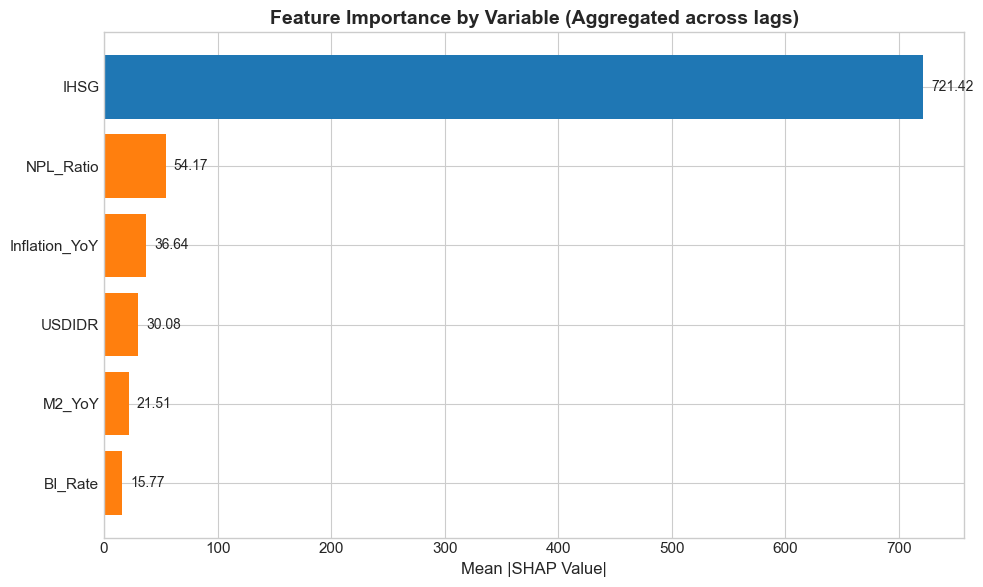

In [ ]:
# Visualization: Aggregated Feature Importance with thesis colors
fig, ax = plt.subplots(figsize=(10, 6))

vars_names = list(sorted_importance.keys())
importances = list(sorted_importance.values())

# Color coding: IHSG = Green (primary), Macroeconomic = use palette
bar_colors = []
for v in vars_names:
    if 'IHSG' in v:
        bar_colors.append(COLORS['IHSG'])
    elif 'Inflation' in v:
        bar_colors.append(COLORS['Inflation'])
    elif 'M2' in v:
        bar_colors.append(COLORS['M2_YoY'])
    elif 'USDIDR' in v:
        bar_colors.append(COLORS['USDIDR'])
    elif 'BI_Rate' in v:
        bar_colors.append(COLORS['BI_Rate'])
    elif 'NPL' in v:
        bar_colors.append(COLORS['NPL_Ratio'])
    else:
        bar_colors.append(COLORS['error'])

bars = ax.barh(vars_names[::-1], importances[::-1], color=bar_colors[::-1])
ax.set_xlabel('Mean |SHAP Value|', fontsize=12)
ax.set_title('Feature Importance by Variable (Aggregated across lags)', fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, importances[::-1]):
    ax.text(val + max(importances)*0.01, bar.get_y() + bar.get_height()/2, 
            f'{val:.2f}', va='center', fontsize=10)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=COLORS['IHSG'], label='Target (IHSG)'),
    Patch(facecolor=COLORS['M2_YoY'], label='Macroeconomic Variables')
]
ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9)

plt.tight_layout()
plt.savefig('feature_importance_aggregated.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: feature_importance_aggregated.png (300 DPI)")

## 11. Results Summary

In [26]:
# Final Summary
print("="*70)
print("HASIL PENELITIAN MODEL 1: IHSG DENGAN VARIABEL MAKROEKONOMI")
print("="*70)

print("\n📊 DATA:")
print(f"   • Periode Data     : {df_clean['Date'].min().strftime('%B %Y')} - {df_clean['Date'].max().strftime('%B %Y')}")
print(f"   • Total Observasi  : {len(df_clean)} bulan")
print(f"   • Train/Test Split : {TRAIN_RATIO*100:.0f}% / {(1-TRAIN_RATIO)*100:.0f}%")

print("\n🎯 TARGET:")
print(f"   • Variabel Target  : IHSG (Indeks Harga Saham Gabungan)")

print("\n📈 COVARIATES (Variabel Makroekonomi):")
for i, col in enumerate(COVARIATE_COLS, 1):
    print(f"   {i}. {col}")

print("\n⚙️ BEST HYPERPARAMETERS (via GridSearch):")
for param, value in best_params.items():
    print(f"   • {param}: {value}")

print("\n📏 MODEL PERFORMANCE:")
print(f"   • MAPE  : {mape_score:.4f}%")
print(f"   • RMSE  : {rmse_score:.4f}")
print(f"   • MAE   : {mae_score:.4f}")
print(f"   • R²    : {r2:.4f}")

print("\n🔍 FEATURE IMPORTANCE (SHAP - Top 3):")
for i, (var, imp) in enumerate(list(sorted_importance.items())[:3], 1):
    pct = (imp / total_importance) * 100
    print(f"   {i}. {var}: {pct:.2f}%")

print("\n" + "="*70)
print("Source: Author's calculation, 2025")
print("="*70)

HASIL PENELITIAN MODEL 1: IHSG DENGAN VARIABEL MAKROEKONOMI

📊 DATA:
   • Periode Data     : January 2015 - January 2025
   • Total Observasi  : 121 bulan
   • Train/Test Split : 80% / 20%

🎯 TARGET:
   • Variabel Target  : IHSG (Indeks Harga Saham Gabungan)

📈 COVARIATES (Variabel Makroekonomi):
   1. Inflation_YoY
   2. M2_YoY
   3. USDIDR
   4. BI_Rate
   5. NPL_Ratio

⚙️ BEST HYPERPARAMETERS (via GridSearch):
   • lags: 12
   • lags_past_covariates: 3
   • n_estimators: 100
   • max_depth: 5

📏 MODEL PERFORMANCE:
   • MAPE  : 3.1449%
   • RMSE  : 285.6206
   • MAE   : 226.3308
   • R²    : -0.1513

🔍 FEATURE IMPORTANCE (SHAP - Top 3):
   1. IHSG: 82.02%
   2. NPL_Ratio: 6.16%
   3. Inflation_YoY: 4.17%

Source: Author's calculation, 2025


In [27]:
# Save results to CSV
results_df = pd.DataFrame({
    'Date': test_actual.time_index,
    'Actual_IHSG': test_actual.values().flatten(),
    'Predicted_IHSG': predictions.values().flatten(),
    'Error': (predictions.values().flatten() - test_actual.values().flatten()),
    'APE_%': np.abs((predictions.values().flatten() - test_actual.values().flatten()) / test_actual.values().flatten()) * 100
})

results_df.to_csv('model1_predictions.csv', index=False)
print("✅ Predictions saved to 'model1_predictions.csv'")

# Display prediction results
results_df.round(2)

✅ Predictions saved to 'model1_predictions.csv'


,Date,Actual_IHSG,Predicted_IHSG,Error,APE_%
0,2023-01-31,6839.34,6969.57,130.23,1.90
1,2023-02-28,6843.24,6983.80,140.56,2.05
2,2023-03-31,6805.28,6987.65,182.38,2.68
3,2023-04-30,6915.72,7002.36,86.64,1.25
4,2023-05-31,6633.26,6985.69,352.43,5.31
5,2023-06-30,6661.88,6987.63,325.75,4.89
6,2023-07-31,6931.36,6978.08,46.72,0.67
7,2023-08-31,6953.26,6988.16,34.90,0.50
8,2023-09-30,6939.89,6986.78,46.89,0.68
9,2023-10-31,6752.21,6983.17,230.96,3.42
